In [79]:
# Importing necessary libraries

import yfinance as yf
from bs4 import BeautifulSoup
import requests

import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import yfinance as yf
import json

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re, string
import nltk
import spacy
from nltk.util import ngrams
from nltk import bigrams, trigrams
import unicodedata
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.probability import FreqDist
from collections import Counter
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation

### Web Scrapping

This function scrapes data from the url. It uses html parser to parse Html content and iterates through n pages and finds all items with class "PageListFeed-items-item" and then extracts the title and descriptions using .get_text() function to get text from the list_item and appends to the data dictionary.

In [2]:
def extract(n):
    data = {'title': [], 'description': []}
    for idx in range(1, n+1):
        res = requests.get(f"https://www.nbcsports.com/?p={idx}")
        soup = BeautifulSoup(res.content, "html.parser")
        list_items = soup.find_all("div", "PageListFeed-items-item")
        for item in list_items:
            title = item.find("div", "PagePromo-title").get_text()
            description = item.find("div", "PagePromo-description").get_text()
            
            data['title'].append(title)
            data['description'].append(description)
            
    df = pd.DataFrame(data)
    return df

In [3]:
# Extracting 500 pages
result_df=extract(1000)

In [4]:
#Resulted dataframe
result_df

,title,description
0,"\nWas wrist wrap a coincidence, or did Joe Bur...",Common sense suggests that he was already inju...
1,\nLamar Jackson “feeling good” after hurting a...,Bengals quarterback Joe Burrow wound up with t...
2,\nOdell Beckham says his shoulder injury is no...,Ravens wide receiver Odell Beckham Jr. left Th...
3,\nBengals’ Mike Hilton: Division might be out ...,The Bengals seem to realize there’s not much h...
4,\nJohn Harbaugh questions why Logan Wilson nee...,Ravens tight end Mark Andrews was lost for the...
...,...,...
4995,\nBengals’ Mike Hilton: Division might be out ...,The Bengals seem to realize there’s not much h...
4996,\nJohn Harbaugh questions why Logan Wilson nee...,Ravens tight end Mark Andrews was lost for the...
4997,\nZac Taylor says Joe Burrow has sprained wrist\n,Bengals head coach head coach Zac Taylor said ...
4998,\nThursday Night Football: Ravens move to 8-3 ...,Cincinnati has a bigger problem than its 5-5 r...


In [98]:
result_df.to_csv("data.csv")

### EXPLORATORY DATA ANALYSIS

In [5]:
# Prints information about dataframe related to data type, non-null values
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        5000 non-null   object
 1   description  5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [6]:
# Statstictial description of the dataframe
result_df.describe()

,title,description
count,5000,5000
unique,2756,2737
top,\nBengals’ Mike Hilton: Division might be out ...,The Bengals seem to realize there’s not much h...
freq,348,348


In [7]:
# Prints total number of dulicated entries in the dataframe
result_df.duplicated().sum()

2244

In [8]:
# Dropping duplicated rows
result_df.drop_duplicates(inplace=True)

In [9]:
result_df.describe()

,title,description
count,2756,2756
unique,2756,2737
top,"\nWas wrist wrap a coincidence, or did Joe Bur...","How to watch this week’s events, from around t..."
freq,1,4


In [10]:
# Checking duplicates value count
result_df.duplicated().value_counts()

False    2756
Name: count, dtype: int64

In [11]:
# result_df.to_csv("dataframe.csv")

In [12]:
# Making of copy of original dataframe as df1
df1 = result_df.copy()

### EDA and Feature Engineering 

In [13]:
# Function that tokenizes sentence and returns total lenght of it
def sent_tokenizer(column):
    tokenized_sent = sent_tokenize(column)
    return(len(tokenized_sent))

In [14]:
# Applying sent_tokenizer function for both 'title' and 'description' column and creating new column that contains lenght of it.
df1['title_sent_count'] = df1['title'].apply(sent_tokenizer)
df1['desc_sent_count'] = df1['description'].apply(sent_tokenizer)

In [15]:
# Function to tokenize word in the column and return lenght of it
def word_tokenizer(column):
    tokenized_word = word_tokenize(column)
    return(len(tokenized_word))

In [16]:
# Applying word_tokenizer function for both 'title' and 'description' column and creating new column that contains lenght of it.
df1['title_word_count'] = df1['title'].apply(word_tokenizer)
df1['desc_word_count'] = df1['description'].apply(word_tokenizer)

 Function that counts lenght of total stopwords present in the text for column. If stopword found it gets appended in stop list

In [17]:
stop_words_list = set(stopwords.words('english'))

def stop_word(column):
    stop = []
    tokenized_words = word_tokenize(column)
    for word in tokenized_words:
        if word.lower() in stop_words_list:
            stop.append(word)
            
    return len(stop) 

In [18]:
# Function that creates two new column that holds the stopword legnth present in 'title' and 'description' column
df1['stop_in_title'] = df1['title'].apply(stop_word)
df1['stop_in_desc'] = df1['description'].apply(stop_word)

In [19]:
# The lambda function calculates the count of character for 'title' column by removing space using .replace("","")
df1['title_char_count'] = df1['title'].apply(lambda x : len(x.replace(" ","")))

In [20]:
# The lambda function calculates the count of character for 'description' column by removing space using .replace("","")
df1['desc_char_count'] = df1['description'].apply(lambda x : len(x.replace(" ","")))

In [21]:
# Defining punc for removing puncutation from the text
punc = string.punctuation

In [22]:
# Using punc to count len of punctutaion present in 'title' and 'description' column
df1['title_punc_count'] = df1['title'].apply(lambda x : len([i for i in x if i in punc]))
df1['desc_punc_count'] = df1['description'].apply(lambda x : len([i for i in x if i in punc]))

This code calculates the length of biagram and trigram. Process function uses word_tokenizer to create tokens from the text from the column. It removes stopword and punctuation from the token and return the output token which is used to count ngrams. If n==2 then it lists as in bigrams token and trigrams tokens for n==3 and returns the length of the list. 

In [23]:
def process(column):
    tokens = word_tokenize(column.lower())
    tokens = [token for token in tokens if token not in stop_words_list and token not in string.punctuation]
    return tokens

def ngrams_count(column,n):
    tokens = process(column)
    if n==2:
        ngram_tokens = list(bigrams(tokens))
        
    elif n==3:
        ngram_tokens = list(trigrams(tokens))
        
    return len(ngram_tokens)    

Passing ngrams_count function for combined column of title and description and creating new column as 'bigram_length' and 'trigram_length' that holds biagram length and trigram length respectively.

In [24]:
df1['bigram_length'] = (df1['title'] + ' ' + df1['description']).apply(lambda x: ngrams_count(x, 2))
df1['trigram_length'] = (df1['title'] + ' ' + df1['description']).apply(lambda x: ngrams_count(x, 3))

In [25]:
df1.head()

,title,description,title_sent_count,desc_sent_count,title_word_count,desc_word_count,stop_in_title,stop_in_desc,title_char_count,desc_char_count,title_punc_count,desc_punc_count,bigram_length,trigram_length
0,"\nWas wrist wrap a coincidence, or did Joe Bur...",Common sense suggests that he was already inju...,1,1,16,18,6,8,70,71,3,2,15,14
1,\nLamar Jackson “feeling good” after hurting a...,Bengals quarterback Joe Burrow wound up with t...,1,1,11,30,1,13,57,135,0,2,24,23
2,\nOdell Beckham says his shoulder injury is no...,Ravens wide receiver Odell Beckham Jr. left Th...,1,1,9,44,3,18,43,160,0,5,27,26
3,\nBengals’ Mike Hilton: Division might be out ...,The Bengals seem to realize there’s not much h...,1,1,19,26,7,11,75,97,2,1,23,22
4,\nJohn Harbaugh questions why Logan Wilson nee...,Ravens tight end Mark Andrews was lost for the...,1,1,15,37,4,13,76,157,1,2,32,31


In [26]:
df1.describe()

,title_sent_count,desc_sent_count,title_word_count,desc_word_count,stop_in_title,stop_in_desc,title_char_count,desc_char_count,title_punc_count,desc_punc_count,bigram_length,trigram_length
count,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000
mean,1.035922,1.039187,12.139332,21.494920,2.871553,7.715530,56.946299,93.225327,1.150218,1.991655,19.635341,18.635341
std,0.193772,0.220351,3.957051,9.879362,2.105781,4.528072,14.573153,43.280695,1.099053,1.513018,6.336210,6.336210
min,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,17.000000,2.000000,0.000000,0.000000,4.000000,3.000000
25%,1.000000,1.000000,9.000000,15.000000,1.000000,5.000000,46.000000,63.000000,0.000000,1.000000,15.000000,14.000000
50%,1.000000,1.000000,12.000000,20.000000,2.000000,7.000000,56.000000,84.000000,1.000000,2.000000,19.000000,18.000000
75%,1.000000,1.000000,15.000000,26.000000,4.000000,10.000000,67.250000,115.000000,2.000000,2.000000,23.000000,22.000000
max,3.000000,4.000000,27.000000,67.000000,15.000000,30.000000,97.000000,301.000000,7.000000,16.000000,44.000000,43.000000


This code plots KDE distribution. Columns that are required for plotting are kept in columns_to_plot list. Then a loop is initiated that loop through each column stored in columns_to_plot.For every value of i it calculates the row index and column index based on the current iteration index i. Seaborn is used to create a 4*3 grid of subplot and plots its kernel Density estimate(KDE) using row and column value calculated as axes.

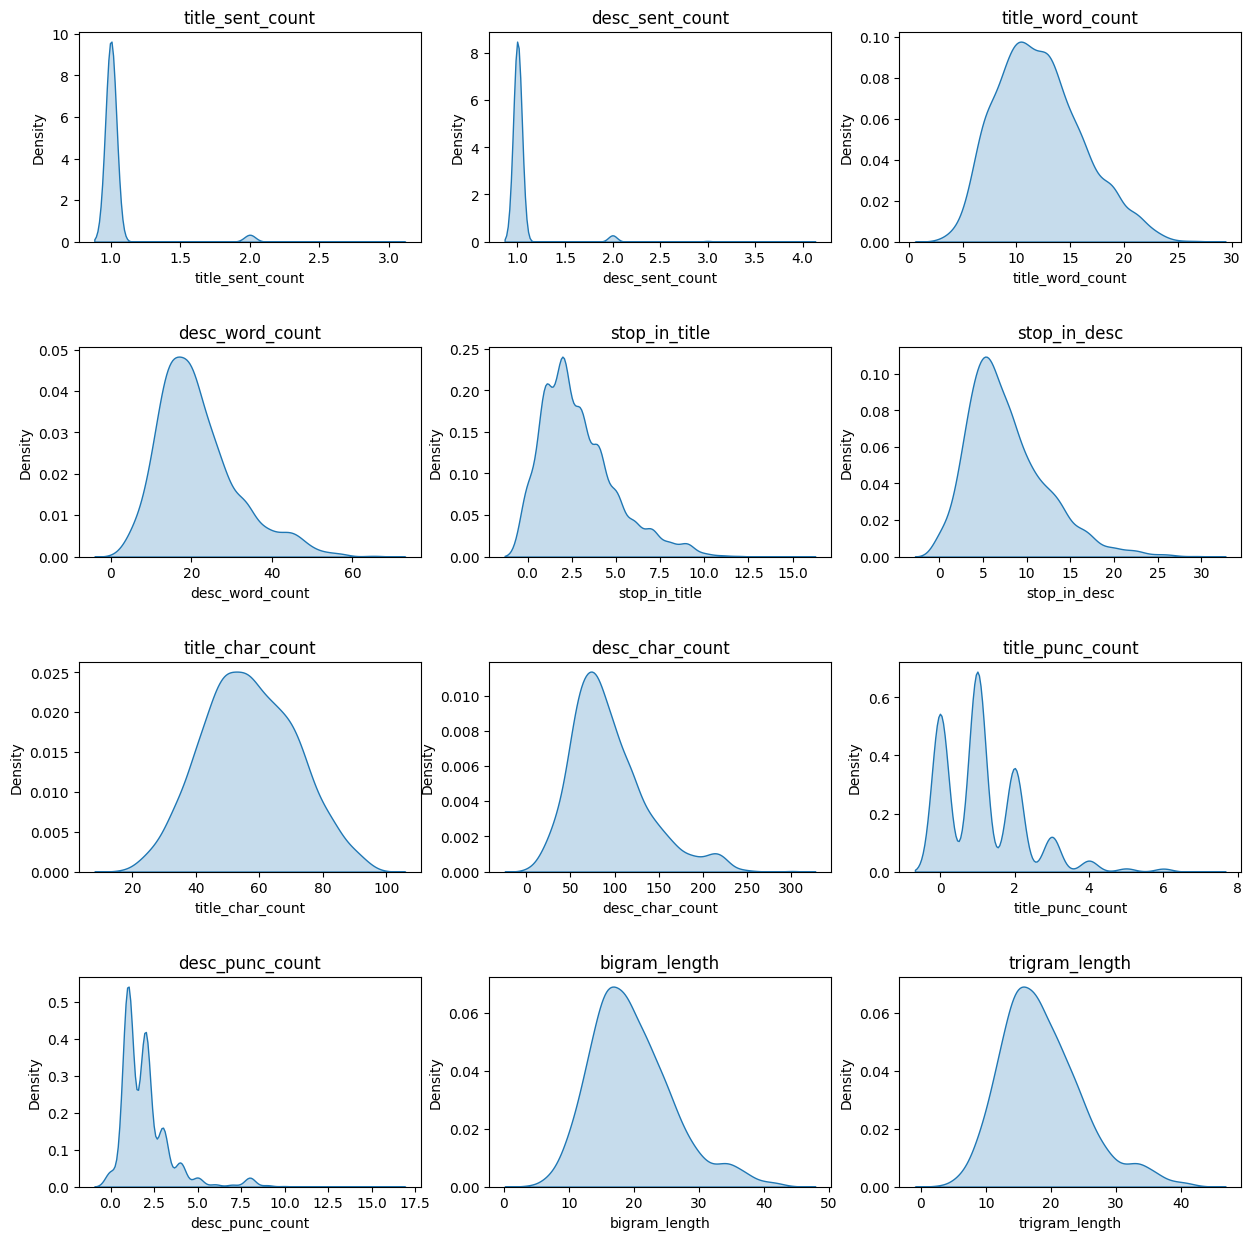

In [27]:
columns_to_plot = ['title_sent_count', 'desc_sent_count', 'title_word_count', 'desc_word_count',
                    'stop_in_title', 'stop_in_desc', 'title_char_count', 'desc_char_count',
                    'title_punc_count', 'desc_punc_count', 'bigram_length', 'trigram_length']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    sns.kdeplot(df1[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(column)

### Word Cloud for 'title' column

This code generates the word cloud visualization for 'title' column. ' '.join() concats all the text into a single string then the string is passed to word cloud generate which takes certain paramater and generates the wordcloud. Interpoltaion is set to bilinear for better image quality. 

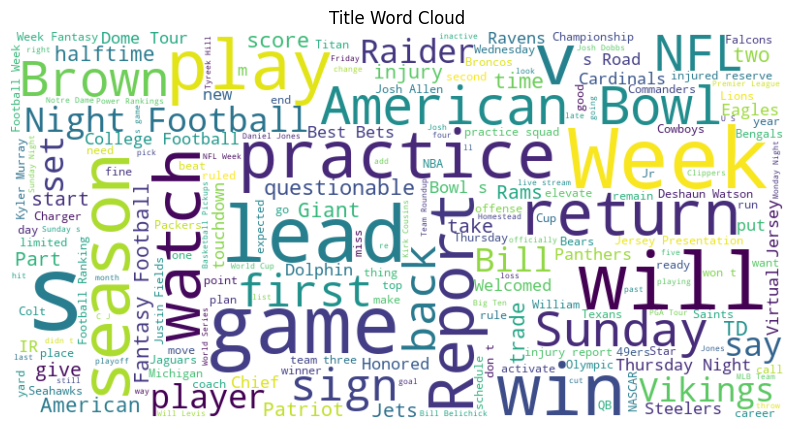

In [28]:
title_text = ' '.join(df1['title'].astype(str).tolist())

title_wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(title_text)
                 
plt.figure(figsize=(10, 7))
plt.imshow(title_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Title Word Cloud')
plt.show()

### Word Cloud for 'description' column

This code generates the word cloud visualization for 'description' column. ' '.join() concats all the text into a single string then the string is passed to word cloud generate which takes certain paramater and generates the wordcloud. Interpoltaion is set to bilinear for better image quality.

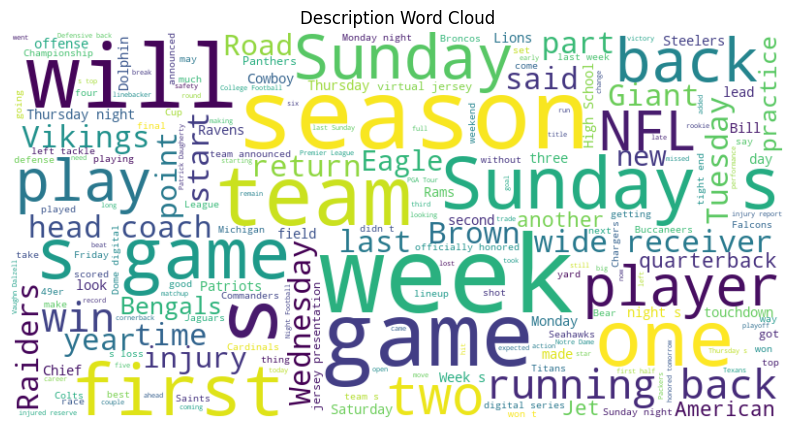

In [29]:
description_text = ' '.join(df1['description'].astype(str).tolist())

description_wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(description_text)
                        
plt.figure(figsize=(10, 7))
plt.imshow(description_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Description Word Cloud')
plt.show()

In [30]:
# Creating new column named 'combined_text' that contains all content of 'title' and 'description' column
df1['combined_text'] = df1['title'] + ' ' + df1['description']

This code generates top common word from the 'combined_text' column. The string is tokenized using word tokenizner and non-alphanumeric characters and stopwords are removed. Counter is used to count the words and .most_common() function is used to state and extract most common words based on 'n'.

In [31]:
combined_text = ' '.join(df1['combined_text'].astype(str).tolist())

def top_common_words(text, n):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words_list]
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(n)
    return top_words

In [32]:
# n=10 is passed and 10 most common words are extracted along with their counts
top_words_result = top_common_words(combined_text, n=10)

if top_words_result:
    print("Top 10 most common words:")
    for word, count in top_words_result:
        print(f"{word}: {count}")
        
    df_top_words = pd.DataFrame(top_words_result, columns=['Word', 'Count'])
   

Top 10 most common words:
week: 718
sunday: 461
season: 391
game: 384
quarterback: 346
back: 336
team: 289
practice: 276
nfl: 273
injury: 271


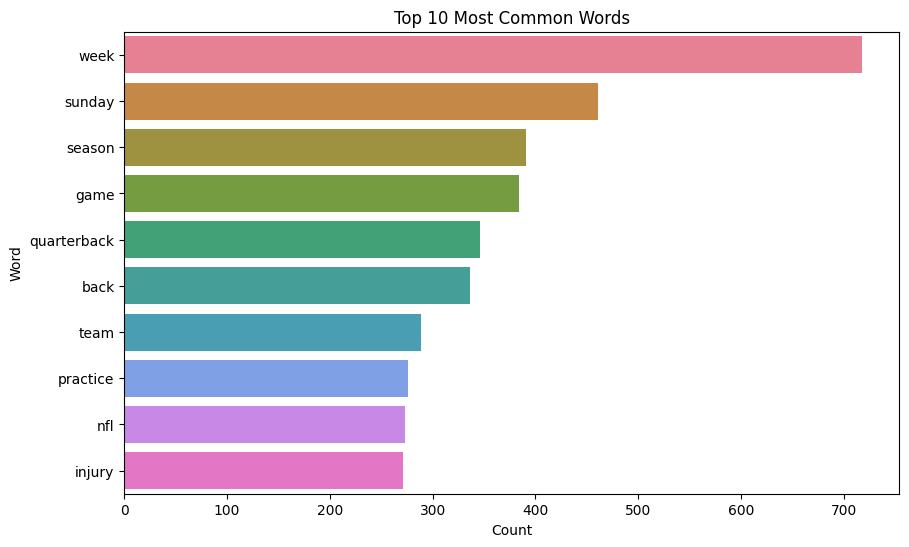

In [33]:
# sns barplot is used to plot the 10 most common words. X axis is count and y is words

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Word', data=df_top_words, hue='Word', palette='husl', legend=False)
plt.title('Top 10 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

### Bigrams and Trigrams generation

This code generates top_ngrams(top_bigrams and top_trigrams) from the combined_text column. The function top_ngrams takes three parameters column, n and ngrams_range which is intially set as unigram(1,1). After tokens are created and filtered it is passed to column and processed_texts are generated which is fitted into the vectorizer model which converts text data into sparse matrix X where each row corresponds to a document, and each column corresponds to unique word or n-gram. The feature names (words or n-grams) are obtained using get_feature_names_out(). The counts of each feature across all documents are calculated, and a dictionary ngram_counts is created with feature names as keys and their counts as values. X.sum(axis=0) calculates sum of each column in sparse martix X whereas .A1 converts the result to 1 dimnesion array. counts represents sum of occurance for the respective feature across all documents in the corpus. The ngram_counts are sorted and x[1] is done to sort based on second element of each tuple. reverse=True indicates sorting to be done from descending order

In [34]:
df1['combined_text'] = df1['title'] + ' ' + df1['description']

def top_ngrams(column, n, ngram_range=(1, 1)):
    
    def process_text(text):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words_list]
        return ' '.join(tokens)

    processed_texts = column.apply(process_text)

    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(processed_texts)
    feature_names = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    ngram_counts = dict(zip(feature_names, counts))
    sorted_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    return sorted_ngrams

In [35]:
# Setting n=10(10 n_grams) ngram_range = (2,2) is for biagram and (3,3) for trigram

top_bigrams = top_ngrams(df1['combined_text'], 10, ngram_range=(2, 2))
top_trigrams = top_ngrams(df1['combined_text'], 10, ngram_range=(3, 3))

print("Top Bigrams:")
for bigram in top_bigrams:
    print(bigram)

print("\nTop Trigrams:")
for trigram in top_trigrams:
    print(trigram)

Top Bigrams:
('thursday night', 102)
('running back', 101)
('sunday game', 101)
('road dome', 96)
('wide receiver', 93)
('virtual jersey', 89)
('jersey presentation', 88)
('week 10', 87)
('head coach', 83)
('night football', 81)

Top Trigrams:
('virtual jersey presentation', 88)
('dome digital series', 56)
('road dome digital', 56)
('2024 virtual jersey', 53)
('jersey presentation part', 53)
('commit officially honored', 48)
('road dome tour', 40)
('bowl road dome', 36)
('2024 bowl virtual', 35)
('2024 part bowl', 35)


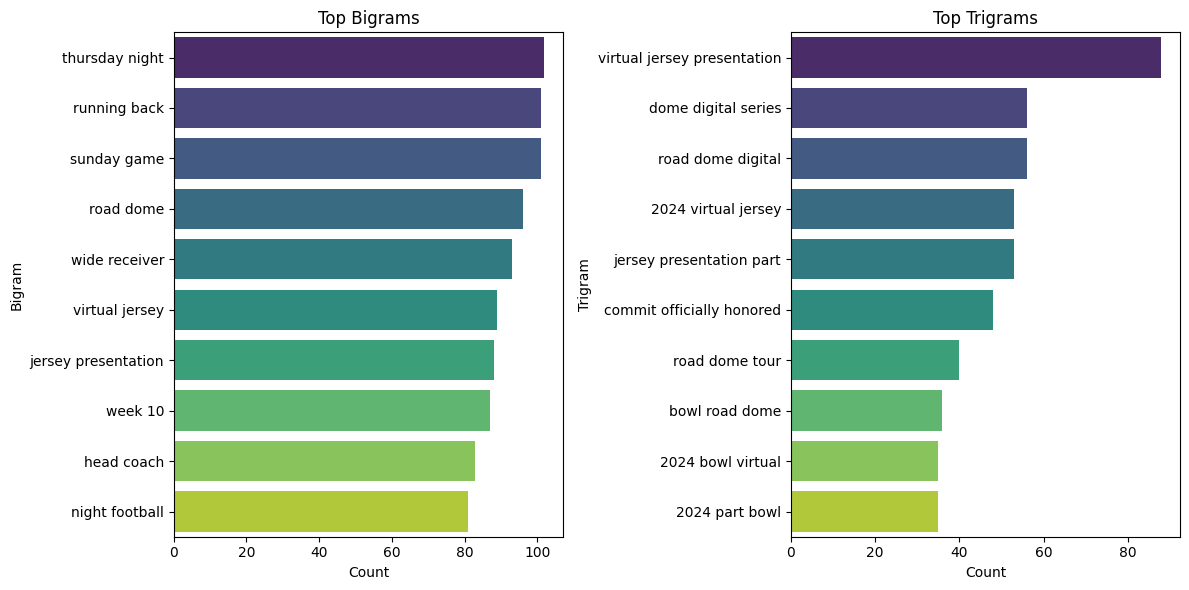

In [36]:
#Creating df1_bigrams and df1_trigrams that contains the top_ngrams and its count

df1_bigrams = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
df1_trigrams = pd.DataFrame(top_trigrams, columns=['Trigram', 'Count'])
plt.figure(figsize=(12, 6))

#Barplot using sns for top bigrams
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Bigram', data=df1_bigrams, palette='viridis', hue='Bigram', legend=False)
plt.title('Top Bigrams')

#Barplot usisng seaborn for top Trigrams
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Trigram', data=df1_trigrams, palette='viridis', hue='Trigram', legend=False)
plt.title('Top Trigrams')

plt.tight_layout()
plt.show()

### POS Tags

This code uses Part-of-speech to show the top 7 most common POS and their counts and plots the barplot for it using seaborn. nltk.pos_tag is used on tokens of 'combined_text' which is stored in tags variable. A loop iterates over each element(i) in the tags list where i represent a list of tuples where each tuple contain a word and its associated POS.The nested loop inside first loop iterates over each tuple(x) within the current list i. x[1] means extracting the second element of tuple which represents POS. Counter counts the POS and if POS tag found it plots a barplot using seaborn.

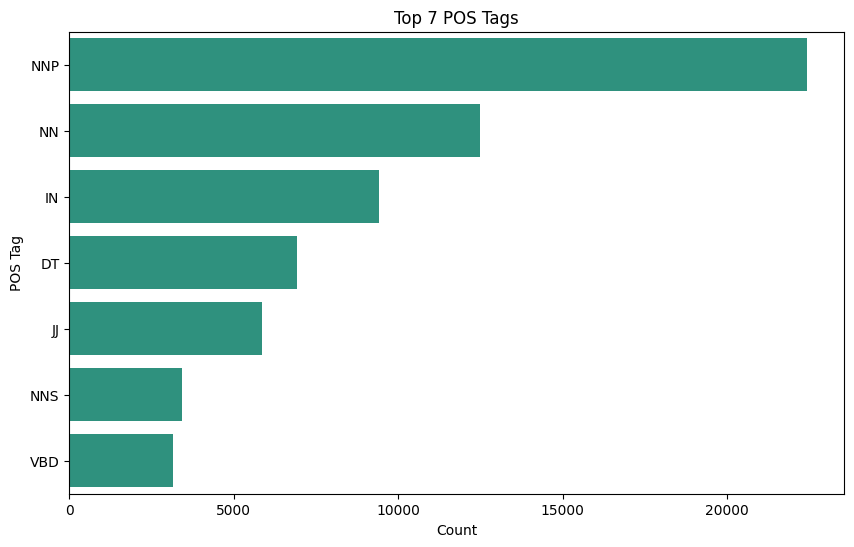

In [37]:
tags = df1['combined_text'].apply(lambda x: nltk.pos_tag(word_tokenize(x)))
tags = [x[1] for i in tags for x in i]

counter = Counter(tags)

if counter:
    x, y = zip(*counter.most_common(7))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=y, y=x, color=sns.color_palette('viridis')[3])
    plt.title('Top 7 POS Tags')
    plt.xlabel('Count')
    plt.ylabel('POS Tag')
    plt.show()

else:
    print("No POS tags found in the text.")


### PREPROCESSING AND WORD VECTORIZATION

In [38]:
df1.head(2)

,title,description,title_sent_count,desc_sent_count,title_word_count,desc_word_count,stop_in_title,stop_in_desc,title_char_count,desc_char_count,title_punc_count,desc_punc_count,bigram_length,trigram_length,combined_text
0,"\nWas wrist wrap a coincidence, or did Joe Bur...",Common sense suggests that he was already inju...,1,1,16,18,6,8,70,71,3,2,15,14,"\nWas wrist wrap a coincidence, or did Joe Bur..."
1,\nLamar Jackson “feeling good” after hurting a...,Bengals quarterback Joe Burrow wound up with t...,1,1,11,30,1,13,57,135,0,2,24,23,\nLamar Jackson “feeling good” after hurting a...


The class 'DataPreprocessing' is designed to perfrom several text preprocesing steps. self.lemmatizer = wordNetlemmatizer() initializes a WordNetlemamtizer as an attribute of class. The text are converted to lowercase and puncutations are removed then token are created using word_tokenizer and stopwords are removed. self.lemmatizer is used to normalize the tokens and the final processed text which are tokens are converted into one string using ' '.join() function.

In [39]:
class DataPreprocessing:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def preprocessing(self,text):
        lower_text = text.lower()
        manipulated_text = lower_text.translate(str.maketrans("","",string.punctuation))
        token_text = word_tokenize(manipulated_text)
        filtered_text = [text for text in token_text if text not in stop_words_list]
        
        lemmatized_tokens = [self.lemmatizer.lemmatize(text) for text in filtered_text]
        processed_text = ' '.join(lemmatized_tokens)
        
        return processed_text

Initializing an instance of DataPreprocessing class as data_preprocessor and applying it to 'title','description' and 'combined_text' columns

In [40]:
data_preprocessor = DataPreprocessing()

df1['title'] = df1['title'].apply(data_preprocessor.preprocessing)
df1['description'] = df1['description'].apply(data_preprocessor.preprocessing)
df1['combined_text'] = df1['combined_text'].apply(data_preprocessor.preprocessing)

In [41]:
df1.head(2)

,title,description,title_sent_count,desc_sent_count,title_word_count,desc_word_count,stop_in_title,stop_in_desc,title_char_count,desc_char_count,title_punc_count,desc_punc_count,bigram_length,trigram_length,combined_text
0,wrist wrap coincidence joe burrow preexisting ...,common sense suggests already injured team tri...,1,1,16,18,6,8,70,71,3,2,15,14,wrist wrap coincidence joe burrow preexisting ...
1,lamar jackson “ feeling good ” hurting ankle t...,bengal quarterback joe burrow wound serious in...,1,1,11,30,1,13,57,135,0,2,24,23,lamar jackson “ feeling good ” hurting ankle t...


### BAG OF WORD

In [42]:
# Making of copy of df1.
df2= df1.copy()

The code uses scikit-learns 'CountVectorizer' to convert the 'combined_text' column of df2 into a bag-of-words(BOW). vectorizer.fit_transform is applied on the column and the count of occurance of words in text is stored in combined_text_bow variable. vectorizer.get_feature_names_out() fucntion is used to print out the feature_names.

In [43]:
vectorizer =CountVectorizer()
combined_text_bow = vectorizer.fit_transform(df2['combined_text'])
print(combined_text_bow.toarray())
print(vectorizer.get_feature_names_out())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00' '02' '03' ... 'zozo' 'zuerlein' 'åberg']


#### Name Entity Recognition for creating a label

Spacy's Name Entity Recognition functionality is used to find out the label or category of the sport which can be used to Text Classification. 

This code defines a function find_category that takes matrix and dataframe as input. It uses Spacy's to identify organization and event entites in the text and stores it in the new column as sport_categories. 

It uses english model(en_core_web_sm). The loop iterates through the rows of the dataframe matrix and finds the value for every row index. doc =nlp(text) processes the generated text using spacy natural language processing. It creates a spacy doc object that contains various linguistic annotations, including tokenization, part-of-speech tagging, and named entity recognition.

In [44]:
nlp = spacy.load("en_core_web_sm")

def find_category(matrix, df):
    sport_categories = []
    for index, row in matrix.iterrows():
        text = ' '.join([word for word, count in zip(row.index, row.values) if count > 0])
        doc = nlp(text)
    
        sport_entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG','EVENT']]
        sport_categories.append(sport_entities)

    df['sport_categories'] = sport_categories
    return df[['combined_text', 'sport_categories']]

In [45]:
# Defining df and matrx and passing find_category function to find the entity.
bow_df = pd.DataFrame(combined_text_bow.toarray(), columns=vectorizer.get_feature_names_out())
find_category(matrix=bow_df, df=df2)

,combined_text,sport_categories
0,wrist wrap coincidence joe burrow preexisting ...,[]
1,lamar jackson “ feeling good ” hurting ankle t...,[]
2,odell beckham say shoulder injury bad raven wi...,[]
3,bengal ’ mike hilton division might reach stil...,[afc bengal]
4,john harbaugh question logan wilson needed use...,[]
...,...,...
2995,joe flacco among quarterback working brown fri...,[]
2996,jason kelce ’ need super bowl loss motivate we...,[]
2997,saquon barkley would lose mind focused contrac...,[cowboy]
3200,joe flacco working brown friday brown announce...,[]


The Name Entity Recognition was done to create a label for text classification and since we didnt got proper label or no label we drop this model and use word vectorizer matrix to develop other model

In [46]:
df2['combined_text'].iloc[0]

'wrist wrap coincidence joe burrow preexisting wrist injury common sense suggests already injured team tried hide'

###  Information Retrival System

The information retrival system uses cosine similarity as a key metric for document similarity. It retrives relevant document from a given corpus in response to user queries.

The code determies a  retrieve_documents that takes user query, matrix, vectorizer, dataframe and num_results. User query is vectorized using specified word vectorization technique and the cosine similarities between the query vector and the document matrix is calculated. The cosine_similarites are sorted and the [:-num_results-1:-1] slicing takes the last num_results elements from the sorted indices array but in reverse order. So, effectively, it selects the top num_results indices with the highest cosine similarities and at last top num results are returned.

In [47]:
def retrieve_documents(query, matrix, vectorizer, df, num_results):
   
    query_vector = vectorizer.transform([query])
     
    cosine_similarities = cosine_similarity(query_vector, matrix).flatten()

    document_indices = cosine_similarities.argsort()[:-num_results-1:-1]
    return df.iloc[document_indices][['combined_text']]

In [48]:
# Setting user query, matrix, vectorizer,df and total_number of result wanted and performing the function to get output.
query = "who won nba"
retrieved_documents = retrieve_documents(query, combined_text_bow, vectorizer, df2,5)
print(retrieved_documents)

                                          combined_text
279   victor wembanyama v chet holmgren nba ’ great ...
1305  motivation coach nba add coach prize pool inse...
2483           nba betting mvp market tatum crash party
2494  nba 202324 future best bet sixth man year imma...
2182  nba best bet player prop oct 26 khris middleto...


In [49]:
df2['combined_text'][109]

'brazil v argentina watch usa en espanol preview titanic matchup coming conmebol world cup qualifying international break lionel messi argentina visit brazil'

Eblow method for K-means clustering

In the function, it iterates over range of a possible cluster number and creates a k-means model with the current number of cluster. The model is fitted and its appended in wcss. Then the graph is plotted for visual representation of optimal cluster than can be selected.

In [50]:
def elbow_method(x):
    wcss = []
    
    for i in range(1, 16):  
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(x)
        wcss.append(kmeans.inertia_)

   
    plt.plot(range(1, 16), wcss)
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')  
    plt.show()

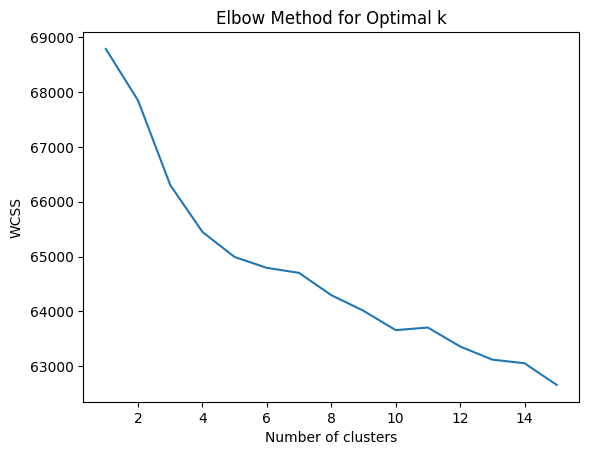

In [51]:
# Plotting elbow method for combined_text_bow
elbow_method(combined_text_bow)

This code applies k-means clustering to the data and assign each row in df2 to a cluster. The optimal number of cluster has been selected to 9 from elbow method and based on that the cluster is made.

In [52]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10)
df2['cluster'] = kmeans.fit_predict(combined_text_bow)

df2[['title', 'description', 'cluster']]

,title,description,cluster
0,wrist wrap coincidence joe burrow preexisting ...,common sense suggests already injured team tri...,4
1,lamar jackson “ feeling good ” hurting ankle t...,bengal quarterback joe burrow wound serious in...,5
2,odell beckham say shoulder injury bad,raven wide receiver odell beckham jr left thur...,1
3,bengal ’ mike hilton division might reach stil...,bengal seem realize ’ much hope winning afc no...,5
4,john harbaugh question logan wilson needed use...,raven tight end mark andrew lost season thursd...,5
...,...,...,...
2995,joe flacco among quarterback working brown friday,brown announced deshaun watson miss rest seaso...,1
2996,jason kelce ’ need super bowl loss motivate week,monday night ’ game eagle chief ninth time pre...,5
2997,saquon barkley would lose mind focused contract,giant running back saquon barkley spotted gett...,1
3200,joe flacco working brown friday,brown announced deshaun watson miss rest seaso...,1


This code performs Principal Component Analysis on the bag-of-word matrix to reduce the dimension and creates pca_1 and pca_2 for cluster visualization 

In [53]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(combined_text_bow.toarray())

df2['pca_1'] = X_pca[:, 0]
df2['pca_2'] = X_pca[:, 1]

X_pca_df = pd.DataFrame(data = X_pca, columns =['pca1','pca2'])
X_pca_df.head()

,pca1,pca2
0,-0.172676,-0.310329
1,-0.366500,-0.349737
2,-0.379499,-0.446082
3,-0.213069,-0.335617
4,-0.289753,-0.378128


This code plots a scatter plot to visaulize the clusters obtained from K-means clustering. It iterates over each clusters and extracts the data points for the cluster and then plt.scatter is used to plot the cluster

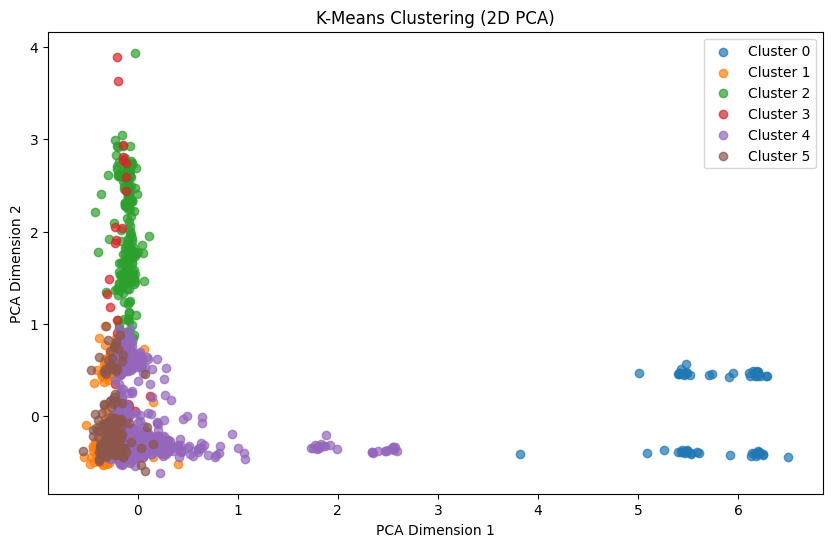

In [54]:
plt.figure(figsize=(10, 6))

for cluster in range(num_clusters):
    cluster_data = df2[df2['cluster'] == cluster]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('K-Means Clustering (2D PCA)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.show()

### Sentiment analysis using TextBlob and RandomForestClassifier

The code uses Textblob to find the sentiment polarity in the text and based on its value sentiment_status column is defined which is used as a label to fit in  RandomForestClassifier model. The dataset is splitted into train test with test=0.2. The model is fitted and X_test value is predicted and accordingly mse and accuracy is calculated. 

Textblob is used to find the sentiment value in the combined_text then threshold is set for categorization of sentiment_status. The new sentiment_status column (y=df['sentiment_status]is used as a label for RandomForestClassifier. The dataset is split and model is fiited on train data and is tested and mse is calculated based on predicitons made. Predicted status is calculated based on same threshold to identify the accuracy of the model. 

In [86]:
def sentiment_analyszer_rfc(x_matrix, df):
    df['sentiment'] = df['combined_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    threshold = 0.1
    df['sentiment_status'] = df['sentiment'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))

    X = x_matrix
    y = df['sentiment_status']

    # Splititng the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    print("Using RandomForest Classifier")
    print(f'Mean Squared Error: {mse:.4f}')

    predicted_status = [1 if pred > threshold else (-1 if pred < -threshold else 0) for pred in predictions]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted_status)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    conf_matrix = confusion_matrix(y_test, predicted_status)
    print('\n')
    print('Confusion Matrix:')
    print(conf_matrix)

### Sentiment analysis using Vader and Support Vector Classifier(SVC)

The code uses vader to find the sentiment polarity in the text and based on its value sentiment_status column is defined which is used as a label to fit in Support Vector Classifier model. The dataset is splitted into train test with test=0.2. The model is fitted and X_test value is predicted and accordingly mse and accuracy is calculated.

Vader is used to find the sentiment value in the combined_text using SentimentIntensityAnalyzer(). analyzer is fiited with this model and the text is passed to it to calculate the sentiment, then threshold is set for categorization of sentiment_status. The new sentiment_status column (y=df['sentiment_status]is used as a label for Support Vector Classifier. The dataset is split and model is fiited on train data and is tested and mse is calculated based on predicitons made. Predicted status is calculated based on same threshold to identify the accuracy of the model.

In [87]:
from sklearn.svm import SVC
from nltk.sentiment import SentimentIntensityAnalyzer

def sentiment_analyszer_svc(x_matrix,df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['combined_text'].apply(lambda x : analyzer.polarity_scores(x)['compound'])
    
    threshold = 0.1
    df['sentiment_status'] = df['sentiment'].apply(lambda x: 1 if x>threshold else (-1 if x< -threshold else 0)) 
    
    X=x_matrix
    y=df['sentiment_status']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    
    model= SVC(random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    print('Using Support Vector Classifier')
    print(f'Mean Squared Error: {mse:.4f}')
    
    predicted_status = [1 if pred > threshold else (-1 if pred < -threshold else 0) for pred in predictions]
    
    accuracy = accuracy_score(y_test, predicted_status)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    conf_matrix = confusion_matrix(y_test, predicted_status)
    print('\n')
    print('Confusion Matrix:')
    print(conf_matrix)

In [88]:
# Using TextBlob and RandomForestClassifier  on bag of word matrix
x_matrix=combined_text_bow

sentiment_analyszer_rfc(x_matrix,df2)

Using RandomForest Classifier
Mean Squared Error: 0.2283
Accuracy: 78.26%


Confusion Matrix:
[[ 60  30   2]
 [ 15 255  13]
 [  0  60 117]]


In [58]:
df2[['combined_text','sentiment','sentiment_status']]

,combined_text,sentiment,sentiment_status
0,wrist wrap coincidence joe burrow preexisting ...,-0.300000,-1
1,lamar jackson “ feeling good ” hurting ankle t...,0.122222,1
2,odell beckham say shoulder injury bad raven wi...,-0.197222,-1
3,bengal ’ mike hilton division might reach stil...,0.350000,1
4,john harbaugh question logan wilson needed use...,0.096032,0
...,...,...,...
2995,joe flacco among quarterback working brown fri...,0.016667,0
2996,jason kelce ’ need super bowl loss motivate we...,0.090278,0
2997,saquon barkley would lose mind focused contrac...,0.000000,0
3200,joe flacco working brown friday brown announce...,0.016667,0


In [90]:
# Using vader and Supprot Vector Classifier on bag of word matrx
x_matrix=combined_text_bow

sentiment_analyszer_svc(x_matrix,df2)

Using Support Vector Classifier
Mean Squared Error: 0.8641
Accuracy: 61.41%


Confusion Matrix:
[[ 73  12  80]
 [  9  45  85]
 [  8  19 221]]


In [60]:
df2[['combined_text','sentiment','sentiment_status']]

,combined_text,sentiment,sentiment_status
0,wrist wrap coincidence joe burrow preexisting ...,-0.7351,-1
1,lamar jackson “ feeling good ” hurting ankle t...,-0.3400,-1
2,odell beckham say shoulder injury bad raven wi...,-0.8910,-1
3,bengal ’ mike hilton division might reach stil...,0.6249,1
4,john harbaugh question logan wilson needed use...,-0.5994,-1
...,...,...,...
2995,joe flacco among quarterback working brown fri...,-0.5267,-1
2996,jason kelce ’ need super bowl loss motivate we...,0.9341,1
2997,saquon barkley would lose mind focused contrac...,-0.3400,-1
3200,joe flacco working brown friday brown announce...,-0.5267,-1


### Topic Modelling using LatentDirichletAllocation(LDA)

LDA is used to identify patterns in the distribution of words across documents and group together documents that share similar thematic content.

lda_model is initialized and n_component 5 is set. A function is defined that takes matrix and vectorizer. The matrix is fit_transformed in lda model and vectorizer.get_feature_names_out() is used to get the feature name of the matrix. The loop iterates over each topic in LDA model. lda_model.components_ contains the topic-word distribution, where each row represents a topic, and each element represents the weight of a word in that topic. print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])) Prints the top words for the current topic. topic.argsort() returns the indices of words in ascending order of their weights in the topic. The slicing [:-num_top_words - 1:-1] retrieves the top words in descending order. lda_result_argmax(axis=1) gives the index of the topic with the maximum weight for each document.

In [61]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42) 

def lda_topic(matrix,vectorizer):
     
    lda_result = lda_model.fit_transform(matrix)

    feature_names = vectorizer.get_feature_names_out()
    num_top_words = 5

    for topic_index, topic in enumerate(lda_model.components_):
        print(f"Topic #{topic_index }:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print("\n")

    df2['lda_topic_distribution'] = lda_result.argmax(axis=1)

    return df2[['combined_text', 'lda_topic_distribution']]


In [62]:
# Passing lda_topic for comined_text_bow and its vectorizer
lda_topic(combined_text_bow,vectorizer)

Topic #0:
injury practice sunday quarterback game


Topic #1:
2024 allamerican part road bowl


Topic #2:
cup sunday win team first


Topic #3:
week game sunday night nfl


Topic #4:
week season league michigan watch




,combined_text,lda_topic_distribution
0,wrist wrap coincidence joe burrow preexisting ...,1
1,lamar jackson “ feeling good ” hurting ankle t...,0
2,odell beckham say shoulder injury bad raven wi...,0
3,bengal ’ mike hilton division might reach stil...,2
4,john harbaugh question logan wilson needed use...,0
...,...,...
2995,joe flacco among quarterback working brown fri...,0
2996,jason kelce ’ need super bowl loss motivate we...,3
2997,saquon barkley would lose mind focused contrac...,3
3200,joe flacco working brown friday brown announce...,0


In [95]:
#Printing perplexity to determine the performance of the model. Lower perplexity is better model
print("Using BoW:\n")
print(f"Perplexity: {lda_model.perplexity(combined_text_bow)}")


Using BoW:

Perplexity: 3723.4591101100445


### TF-IDF

In [64]:
#Making a copy of df1 as df3 to perform for TF-IDF
df3 = df1.copy()

The code uses scikit-learns 'TfidfVectorizer' to convert the 'combined_text' column of df2 into a TF-IDF. tfidf_vectorizer.fit_transform is applied on the column and the count of occurance of words in text is stored in tfidf_matrix variable. tfidf_vectorizer.get_feature_names_out() fucntion is used to print out the feature_names.

In [65]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df3['combined_text'])
tfidf_array = tfidf_matrix.toarray()
print(tfidf_vectorizer.get_feature_names_out())

['00' '02' '03' ... 'zozo' 'zuerlein' 'åberg']


Finding Name Entity Recognition with TF-IDF approach

In [66]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
find_category(matrix=tfidf_df, df=df2)

,combined_text,sport_categories
0,wrist wrap coincidence joe burrow preexisting ...,[]
1,lamar jackson “ feeling good ” hurting ankle t...,[]
2,odell beckham say shoulder injury bad raven wi...,[]
3,bengal ’ mike hilton division might reach stil...,[afc bengal]
4,john harbaugh question logan wilson needed use...,[]
...,...,...
2995,joe flacco among quarterback working brown fri...,[]
2996,jason kelce ’ need super bowl loss motivate we...,[]
2997,saquon barkley would lose mind focused contrac...,[cowboy]
3200,joe flacco working brown friday brown announce...,[]


Information Retrival System with TF-IDF approach. matrix is tfidf_matrix, vectroizer is tfidf_vectorizer and dataframe is for df3

In [67]:
query = "who won nba"
retrieved_documents = retrieve_documents(query, tfidf_matrix, vectorizer=tfidf_vectorizer, df=df3,num_results=5)
print(retrieved_documents)

                                          combined_text
1305  motivation coach nba add coach prize pool inse...
279   victor wembanyama v chet holmgren nba ’ great ...
2483           nba betting mvp market tatum crash party
2494  nba 202324 future best bet sixth man year imma...
2182  nba best bet player prop oct 26 khris middleto...


K-means clustering using TF-IDF word vectorization

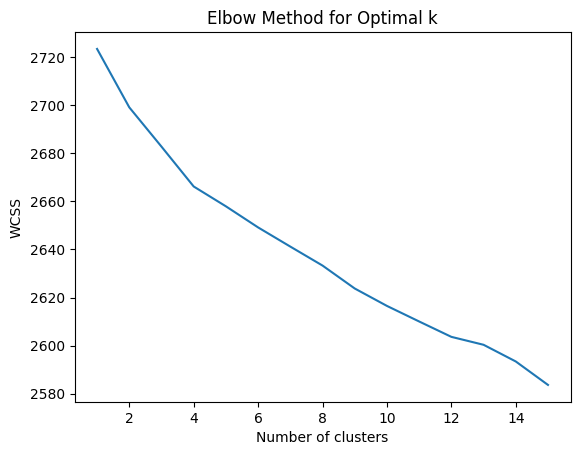

In [68]:
elbow_method(tfidf_matrix)

In [91]:
# Setting optimal cluster 4 for tfidf matrix 
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10)
df3['cluster'] = kmeans.fit_predict(tfidf_matrix)

df3[['title', 'description', 'cluster']]

,title,description,cluster
0,wrist wrap coincidence joe burrow preexisting ...,common sense suggests already injured team tri...,2
1,lamar jackson “ feeling good ” hurting ankle t...,bengal quarterback joe burrow wound serious in...,0
2,odell beckham say shoulder injury bad,raven wide receiver odell beckham jr left thur...,0
3,bengal ’ mike hilton division might reach stil...,bengal seem realize ’ much hope winning afc no...,0
4,john harbaugh question logan wilson needed use...,raven tight end mark andrew lost season thursd...,0
...,...,...,...
2995,joe flacco among quarterback working brown friday,brown announced deshaun watson miss rest seaso...,0
2996,jason kelce ’ need super bowl loss motivate week,monday night ’ game eagle chief ninth time pre...,2
2997,saquon barkley would lose mind focused contract,giant running back saquon barkley spotted gett...,2
3200,joe flacco working brown friday,brown announced deshaun watson miss rest seaso...,0


In [92]:
# Performing PCA for tfidf_matrix
pca = PCA(n_components=2)
Xtf_pca = pca.fit_transform(tfidf_matrix.toarray())

df3['pca_1'] = Xtf_pca[:, 0]
df3['pca_2'] = Xtf_pca[:, 1]

Xtf_pca_df = pd.DataFrame(data = Xtf_pca, columns =['pca1','pca2'])
Xtf_pca_df.head()

,pca1,pca2
0,-0.015291,-0.039913
1,-0.054056,-0.057067
2,-0.039681,-0.069988
3,-0.028321,-0.044207
4,-0.027443,-0.044111


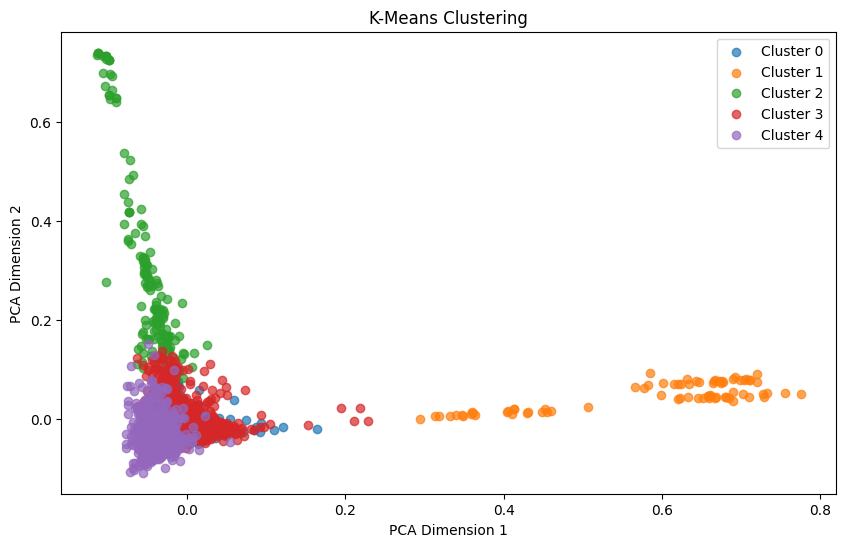

In [71]:
#Plotting PCA visualization
plt.figure(figsize=(10, 6))

for cluster in range(num_clusters):
    cluster_data = df3[df3['cluster'] == cluster]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('K-Means Clustering')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.show()

Sentiment Analaysis using TF-IDF as word vectorization approach

Using TextBlob and RandomForest Classifier

In [93]:
x_matrix=tfidf_matrix

sentiment_analyszer_rfc(x_matrix,df3)

Using RandomForest Classifier
Mean Squared Error: 0.2373
Accuracy: 76.81%


Confusion Matrix:
[[ 56  35   1]
 [ 16 252  15]
 [  0  61 116]]


In [73]:
df3[['combined_text','sentiment','sentiment_status']]

,combined_text,sentiment,sentiment_status
0,wrist wrap coincidence joe burrow preexisting ...,-0.300000,-1
1,lamar jackson “ feeling good ” hurting ankle t...,0.122222,1
2,odell beckham say shoulder injury bad raven wi...,-0.197222,-1
3,bengal ’ mike hilton division might reach stil...,0.350000,1
4,john harbaugh question logan wilson needed use...,0.096032,0
...,...,...,...
2995,joe flacco among quarterback working brown fri...,0.016667,0
2996,jason kelce ’ need super bowl loss motivate we...,0.090278,0
2997,saquon barkley would lose mind focused contrac...,0.000000,0
3200,joe flacco working brown friday brown announce...,0.016667,0


Using Vader Sentiment Analsysis and Support Vector Classifier

In [89]:
x_matrix=tfidf_matrix

sentiment_analyszer_svc(x_matrix,df3)

Using Support Vector Classifier
Mean Squared Error: 0.9493
Accuracy: 58.33%


Confusion Matrix:
[[ 67   6  92]
 [  9  22 108]
 [  6   9 233]]


In [75]:
df3[['combined_text','sentiment','sentiment_status']]

,combined_text,sentiment,sentiment_status
0,wrist wrap coincidence joe burrow preexisting ...,-0.7351,-1
1,lamar jackson “ feeling good ” hurting ankle t...,-0.3400,-1
2,odell beckham say shoulder injury bad raven wi...,-0.8910,-1
3,bengal ’ mike hilton division might reach stil...,0.6249,1
4,john harbaugh question logan wilson needed use...,-0.5994,-1
...,...,...,...
2995,joe flacco among quarterback working brown fri...,-0.5267,-1
2996,jason kelce ’ need super bowl loss motivate we...,0.9341,1
2997,saquon barkley would lose mind focused contrac...,-0.3400,-1
3200,joe flacco working brown friday brown announce...,-0.5267,-1


Topic Modelling Using LDA (TF-IDF word vectorization)

In [76]:
lda_topic(tfidf_matrix,tfidf_vectorizer)

Topic #0:
practice injury sunday quarterback game


Topic #1:
allamerican 2024 watson road dome


Topic #2:
cup race championship week sunday


Topic #3:
week game sunday football night


Topic #4:
week raider season league game




,combined_text,lda_topic_distribution
0,wrist wrap coincidence joe burrow preexisting ...,4
1,lamar jackson “ feeling good ” hurting ankle t...,0
2,odell beckham say shoulder injury bad raven wi...,0
3,bengal ’ mike hilton division might reach stil...,0
4,john harbaugh question logan wilson needed use...,3
...,...,...
2995,joe flacco among quarterback working brown fri...,0
2996,jason kelce ’ need super bowl loss motivate we...,3
2997,saquon barkley would lose mind focused contrac...,3
3200,joe flacco working brown friday brown announce...,0


In [96]:
print("Using TF-IDF:\n")
print(f"Perplexity: {lda_model.perplexity(tfidf_matrix)}")

Using TF-IDF:

Perplexity: 16004.414224759372


Specualation from model developed using bag of word and Tf-idf vectorizer: While using bag of word we were able to achieve higher accuracy on models like sentiment analysis using different classifier, on clustering and on LDA. This might be due to text content in our dataframe.